In [1]:
set.seed(123)
par(mar = c(4,4,1,1))
nSamples <- 250
height<-rnorm(nSamples, 180, 20)
sex<-as.factor(sample(c("male", "female"), size = nSamples, replace = TRUE, prob = c(0.45,0.55)))
height<-height + rnorm(nSamples, 10,5)*(as.numeric(sex)-1)
age<-floor(runif(nSamples, 40,60))
weight<- height * 0.7 - 44 + rnorm(nSamples,0,12)

weight<-weight + rnorm(nSamples, 3, 2)*(as.numeric(sex)-1) + rnorm(nSamples, 0.005, 0.001)*(as.numeric(sex)-1) * height
weight <- weight + age * rnorm(nSamples, 0.04, 0.03)
bmi <- weight/(height/100)^2

smoker<-sample(c(0,1), size = nSamples, replace = TRUE, prob = c(0.8,0.2))
t2diabetes <- sample(c(0,1), size = nSamples, replace = TRUE, prob = c(0.8,0.2))
t2diabetes[sample(which(bmi > 25),10)]<-1
t2diabetes[sample(which(smoker == 1),5)]<-1

exercise_hours <- rpois(nSamples, 1) + rpois(nSamples, 2)*(1-t2diabetes) + rpois(nSamples, 1) * (as.numeric(sex)-1)
alcohol_units <- rpois(nSamples, 3) + rpois(nSamples, 5)*(1-t2diabetes) + rpois(nSamples, 3) * (as.numeric(sex)-1) + rpois(nSamples, 1)*rpois(nSamples, 6)*(1-t2diabetes) 
exercise_hours[which(weight < 60)]<-rpois(sum(weight < 60), 12)
alcohol_units[which(bmi > 37)]<-alcohol_units[which(bmi > 37)] + rpois(sum(bmi > 37),5)
alcohol_units[which(weight > 140)]<-rpois(sum(weight > 140),50)

ethnicity<-sample(c("European", "Asian", "AfricanAmerican"), nSamples, replace = TRUE, prob = c(0.6,0.25,0.15))
socioeconomic_status <- sample(c("High", "Middle", "Low"), nSamples, replace = TRUE, prob = c(0.25,0.5,0.25))
socioeconomic_status[which(bmi > 25)] <- sample(c("High", "Middle", "Low"), sum(bmi > 25), replace = TRUE, prob = c(0.1,0.25,0.65))

demoDat <-data.frame(age, height, weight, bmi, ethnicity, socioeconomic_status, smoker, exercise_hours, alcohol_units, t2diabetes)

# Logistic Regression

## Learning Objectives 
- Learn the purpose of logistic regression and how it differs from linear regression, particularly for predicting binary outcomes.
- Understand the logistic function and how it transforms linear combinations of predictor variables into probabilities.
- Gain proficiency in using the `glm()` function in R to fit logistic regression models and interpret the output.
- Learn to interpret the coefficients of logistic regression models, including their transformation to odds ratios.
- Understand and validate the assumptions underlying logistic regression, such as the appropriate handling of non-continuous outcome variables.

So far all the examples have assumed we have a continous outcome we want to predict. But this is unlikely to be the case all of the time. What if we want to predict a binary variable, such as case control status or another type of indicator variable. We can't use the traditional linear regression techniques we have discussed so far because our outcome is now discrete (coded 0 or 1) but our linear combination of predictor variables can take value. We need to use a function to translate this continous value into our 0,1 discrete code. 

To do this we use the logistic function, and hence this class of regression models is called logistic regression. 

The logistic function is defined as 

$$\sigma(t) = \frac{e^t}{e^t+1}$$

We can visualise the transform between the right-hand side and the left-hand side of the equation in the graph below

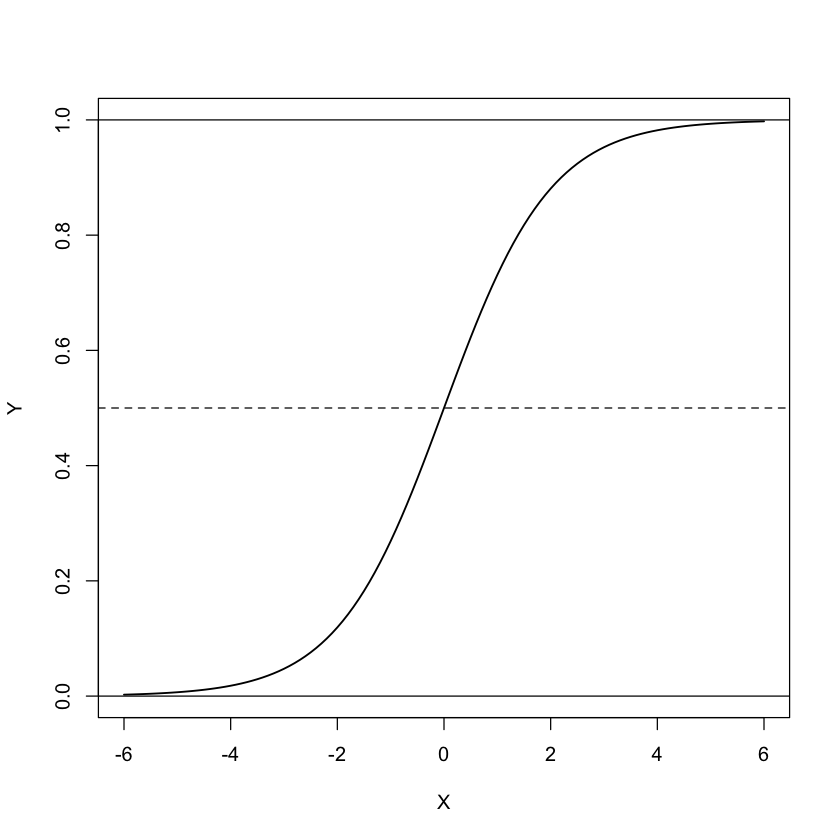

In [2]:
xseq <- seq(-6,6, 0.1)
yseq <- exp(xseq)/(exp(xseq)+1)

plot(xseq, yseq,type = "l", xlab = "X", ylab = "Y", lwd = 1.5)
abline(h = 0.5, lty = 2)
abline(h = 1)
abline(h = 0)

While the combination of X variables can take any value from - infinity to infinity, the Y value is constrained to between 0 and 1. It is still a continous function, so we haven't quite got to our desired outcome of a binary 0,1 variable. With Y now constrained to fall between 0 and 1 we can interpet it as a probability, the probability of being a case. To transform this to taken either the value 0 or the value 1, we apply a threshold of 0.5. If the predicted Y > 0.5 then Y is that observation is classed as a case (i.e. Y = 1) whereas if predicted Y < 0.5, then that observation is classed as a control (i.e. Y = 0). In an ideal world we want our predictions to be definitive. So as well as being constrained to giving a value between 0 and 1, the transformation also has the desirable property of spending most of it's time at the extremes (i.e. 0 or 1) and not much time in the middle (i.e. around 0.5).

After applying the link function, technically, logistic regression is estimating the log odds of being a case. So our equation becomes 

$$ln(odds) = ln(\frac{p}{(1-p)}) = \beta_0 + \beta_1*x$$

We are no longer in the class of linear regression, we are in a more general class of generalised linear models. These permit a more varied number of regression models with different types of outcomes.They use a link function to transform from the unbounded prediction on the right-hand side to the properties of the outcome variable on the left-hand side. For logistic regression, the link function is the logistic function. This means we also need a new R function, `glm()` to fit them. 

Let's look at an example. We are going to predict Type II diabetes status from BMI.

In [3]:
model.log <- glm(t2diabetes ~ bmi, data = demoDat, family = "binomial")

summary(model.log)


Call:
glm(formula = t2diabetes ~ bmi, family = "binomial", data = demoDat)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)
(Intercept) -1.23582    0.90700  -1.363    0.173
bmi          0.01182    0.03398   0.348    0.728

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 298.35  on 249  degrees of freedom
Residual deviance: 298.23  on 248  degrees of freedom
AIC: 302.23

Number of Fisher Scoring iterations: 4


The output takes a very similar format to the `lm()` output. What differences can you notice?

* Instead of residuals we have deviance residuals.

* Instead of t-statistics we have z-statistics.

* Instead of the sums of squares statistics and F-test, we have deviance statistics and no automatic overall test for the full model.


## Interpretation of Regression Coefficients

Remember that in the logistic regression model the response variable is log odds. So we can write the equation we are trying to fit as: 

$$ln(odds) = ln(\frac{p}{(1-p)}) = \beta_0 + \beta_1BMI$$

As with linear regression, the regression coefficients give the change in the predicted value for a one unit increase in the predictor variable. Except, as our predicted value is a log odds ratio, the meaning of the coefficients changes. In logistic regression, the estimated regression coefficients represent log odds ratios per a unit increase in the predictor variable. We can covert these to odds ratios by raising as a power to e, as follows:


In [4]:
exp(coef(model.log))

(Intercept)         bmi 
  0.2905974   1.0118874

We can see that the odds ratios is `r signif(exp(coef(model.log))["bmi"], 3)` which can be reported as for a 1 unit increase of BMI an individual is `r signif(exp(coef(model.log))["bmi"], 3)` times more likely to develop Type II Diabetes. This effect is not very big!

Significance testing is conceptually the same as for linear regression, whereby each regression coefficient (i.e. log odds ratio) is tested to see if it is non-zero. It differs though how it is calculated. As we are no longer able to derive an exact solution, we have to use an iterative method to find the best estimates. This means you sometimes might get warnings that your model failed to converge. This means that the algorithm was not able to settle on an appropriate solution for the best regression coefficients and the result should be treated with caution. Typically, this is due to not enough data or trying to fit too many predictor variables simultaneously or a poor choice of model between X and Y. 

We can get the results of hypothesis testing for the regression coefficients in the same way as we did for linear regression:


In [5]:
summary(model.log)$coefficients

,Estimate,Std. Error,z value,Pr(>|z|)
(Intercept),-1.23581663,0.90699516,-1.3625394,0.1730277
bmi,0.01181734,0.03398161,0.3477568,0.7280228


Unsurprisingly our small increase in the odds of developing Type II diabetes per unit of BMI is not significant. 

To extract the confidence interval of the estimated regression coefficient we can use the inbuilt function `confint()`. The default is to provide the 95% confidence intervals, but we can tailor this function to calculate whichever percentile we want by setting the argument `level`. If we report our estimated coefficient as an odds ratio, we also need to convert the limits of confidence interval. This is done in exactly the same way as for the regression coefficients.


In [6]:
## First on log odds ratio scale
confint(model.log, level = 0.95)

## Second on odds ratio scale
exp(cbind(OR = coef(model.log), confint(model.log, level = 0.95)))


Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-3.02954094,0.53924673
bmi,-0.05531009,0.07843989


Waiting for profiling to be done...



,OR,2.5 %,97.5 %
(Intercept),0.2905974,0.04833782,1.714715
bmi,1.0118874,0.94619169,1.081598


We can use the confidence interval to determine whether our estimated regression coefficient has a non-zero effect, by whether it contains the null value. For example, at a significance level of $\alpha = 0.05$, if the estimated coefficient is significantly non-zero (i.e. $p-value < 0.05$) then the 100(1-$\alpha$) = 95% confidence interval will not contain 0. The null value for the log(OR) is 0, and the null value for the OR is 1. Therefore, if we don't convert our confidence interval to the correct units, we may draw the wrong conclusion. 

Logistic regression is all about appropriately handling the non-continuous outcome variable. The predictor variables can be as complex as your dataset can handle and include categorical variables etc. in the same way as we described for linear regression. 

Let's practise some examples:

## Logistic Regression with Multiple Predictor Variables Exercise

*Fit a logistic regression model to test for an association between age and type II diabetes status*


In [7]:
summary(glm(t2diabetes ~ age, data = demoDat))


Call:
glm(formula = t2diabetes ~ age, data = demoDat)

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept) 0.222802   0.248104   0.898    0.370
age         0.001236   0.004976   0.248    0.804

(Dispersion parameter for gaussian family taken to be 0.2049329)

    Null deviance: 50.836  on 249  degrees of freedom
Residual deviance: 50.823  on 248  degrees of freedom
AIC: 317.19

Number of Fisher Scoring iterations: 2


In [8]:
# Call the function to display quiz interactively:
source("../../R_functions/quiz_renderer.R")
show_quiz_from_json("questions/logistic_regression.json")

What is the odds ratio for Type II Diabetes for each year of age? 
 0.22 
 0.001 
 1.25 
 1.00 
 
 Submit

*Fit a logistic regression model to test for an association between age, alcohol units and exercise time and type II diabetes status*

In [9]:
summary(glm(t2diabetes ~ age + exercise_hours + alcohol_units, data = demoDat))


Call:
glm(formula = t2diabetes ~ age + exercise_hours + alcohol_units, 
    data = demoDat)

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.563377   0.199401   2.825 0.005111 ** 
age             0.003480   0.003949   0.881 0.379029    
exercise_hours -0.025299   0.007248  -3.490 0.000572 ***
alcohol_units  -0.028754   0.002655 -10.830  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 0.1282397)

    Null deviance: 50.836  on 249  degrees of freedom
Residual deviance: 31.547  on 246  degrees of freedom
AIC: 201.97

Number of Fisher Scoring iterations: 2


In [10]:
# Call the function to display quiz interactively:
source("../../R_functions/quiz_renderer.R")
show_quiz_from_json("questions/logistic_regression_2.json")

What is the odds ratio for Type II Diabetes per one hour of exercise? 
 1.76 
 1.00 
 0.98 
 0.97 
 
 Submit
 
 Which of these statements is true? 
 More exercise increases the risk of Type II Diabetes 
 Less exercise increases the risk of Type II Diabetes 
 
 Submit

*Fit a logistic regression model to test for an association between socioeconomic status and type II diabetes status, controlling for age and BMI.*

In [11]:
model.log.full<-glm(t2diabetes ~ age + bmi + ethnicity, data = demoDat)
model.log.null<-glm(t2diabetes ~ age + bmi, data = demoDat)
anova(model.log.null, model.log.full, test = "Chisq")


,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,247,50.80068,NA,NA,NA
2,245,48.64191,2,2.158776,0.004353953


In [12]:
# Call the function to display quiz interactively:
source("../../R_functions/quiz_renderer.R")
show_quiz_from_json("questions/logistic_regression_3.json")

Does socioeconomic status have a significant effect on the odds of Type II Diabetes? 
 Yes 
 No 
 
 Submit
 
 Considering the estimated regression coefficients for the two binary variables for ethnicity, which of the following statements are correct? Ignore the P-values we are just interested in interpreting the regression coefficients. Select all that apply. 
 Asians are associated with decreased risk of Type II Diabetes relative to African Americans. 
 Asians are associated with increased risk of Type II Diabetes relative to African Americans. 
 Asians are associated with decreased risk of Type II Diabetes relative to Europeans. 
 Asians are associated with increased risk of Type II Diabetes relative to Europeans. 
 
 Submit



You may have noticed in the last example above that while the ANOVA for the ethnicity variable was significant, neither of the two dummy variables were significantly associated at P < 0.05. The `ethnicityEuropean` showed a trend for significance with P~0.05. This happens sometimes because when you use an ANOVA to test for the joint effect of both dummy variables, you are using a 2 degree of freedom test (see third column in the ANOVA output), while in the tests for the individual coefficients you are using a 1 degree of freedom test. Mathematically the threshold for a two degree of freedom test is slightly lower to be significant. You could think of this as rather than needing a really strong effect in one variable, a small effect but in both variables would be meaningful. In reality, these results are not contradicting each other, it's just a chance thing related to the fact that we have used a hard threshold to determine significance. Where you only just have enough statitstical power to detect an effect, it is chance whether it falls just above the threshold or just below. 

## Predictions with the Logistic Regression Model

We are going to make some predictions from a logistic regression model to show how the model goes from a weighted sum of prediction variables to the binary outcome variable. 

Let's revisit the example of predicting type II diabetes as a function of alcohol units and exercise hours. First, we need to fit the model.


In [13]:
model.log <- glm(t2diabetes ~ exercise_hours + alcohol_units, data = demoDat)

summary(model.log)$coefficients

,Estimate,Std. Error,t value,Pr(>|t|)
(Intercept),0.73476667,0.044008474,16.69603,2.101286e-42
exercise_hours,-0.02563299,0.007235091,-3.54287,4.731153e-04
alcohol_units,-0.02858291,0.002646709,-10.79941,1.604914e-22


Using our estimated regression coefficients we can write our fitted regression model as `r logEq`.

In [14]:
logEq<- paste0("$\frac{\text{ln(p(TypeIIDiabetes))}}{(1-p(TypeIIDiabetes))}", signif(coef(model.log)[1],2), " + ", signif(coef(model.log)[2],2), " * ExerciseHours + ", 
        signif(coef(model.log)[3],2), " * AlcoholUnits$")




Let's say we have a new observation we want to make a prediction for, we know that they exercise for on average 4 hours a week and consume 10 units of alcohol per week. We can input these values into our equation to estimate the log odds of this individual having type II diabetes. 


In [15]:
## calculate log odds for individual
(logOdds <- coef(model.log)[1] + 
              coef(model.log)[2] * 4 + 
              coef(model.log)[3] * 10)


(Intercept) 
  0.3464056

While by chance this value looks like a probability, we need to do some more transformations to get it to a probability. First we convert from log odds to odds:

In [16]:
## convert to odds
(odds<-exp(logOdds))

(Intercept) 
   1.413976

Next, we convert from odds to probability of being a case.

In [17]:
## convert to a probability
(prob<-odds/(odds+1))

(Intercept) 
  0.5857457

The final step to convert this to a binary case/control status is to apply the threshold 0.5: if the probability is > 0.5 then they are classed as a case and if the probability is < 0.5 they are classed as a control. In this example the probability is just above 0.5 and therefore they would be predicted as a case. However, the estimated probability is not exactly 0, which gives a sense of how imprecise/insensitive our prediction based on this model might be. 



## Logistic regression assumptions


The assumptions for logistic regression are:

* Dependent (i.e. outcome) variable is binary
* No outliers in continuous predictors
* No multicollinearity between predictors


Unlike with linear regression, R doesn't automatically generate plots to assess the validity of the model assumptions. The only real assumption we can check is that there is a linear relationship between continuous predictor variables and the logit of the outcome. This can be done by visually inspecting the scatter plot between each predictor and the logit values.


In [18]:
# Call the function to display quiz interactively:
source("../../R_functions/quiz_renderer.R")
show_quiz_from_json("questions/summary_logistic_regression.json")

What is the primary purpose of logistic regression? 
 To predict a continuous outcome 
 To predict a binary outcome 
 To calculate the mean of a dataset 
 To determine the variance of a dataset 
 
 Submit
 
 How do you interpret the coefficients in a logistic regression model? 
 As changes in the mean outcome 
 As log odds ratios 
 As variance estimates 
 As correlation coefficients 
 
 Submit
 
 What does a p-value less than 0.05 indicate in the context of logistic regression? 
 The coefficient is significantly different from zero 
 The model is invalid 
 The predictor variable is not normally distributed 
 The residuals are normally distributed 
 
 Submit